In [72]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [2]:
fourteen_class_labels = [  
    'Atelectasis',
    'Cardiomegaly',
    'Consolidation',
    'Edema',
    'Enlarged Cardiomediastinum',
    'Fracture',
    'Lung Lesion',
    'Lung Opacity',
    'No Finding',
    'Pleural Effusion',
    'Pleural Other',
    'Pneumonia',
    'Pneumothorax',
    'Support Devices']

nine_class_labels = [
    'lung opacity', 
    'pleural effusion', 
    'atelectasis', 
    'enlarged cardiac silhouette',
    'pulmonary edema/hazy opacity', 
    'pneumothorax', 
    'consolidation', 
    'fluid overload/heart failure', 
    'pneumonia']

anatomy_names = [
    'right lung',
    'right apical zone',
    'right upper lung zone',
    'right mid lung zone',
    'right lower lung zone',
    'right hilar structures',
    'right costophrenic angle',
    'left lung',
    'left apical zone',
    'left upper lung zone',
    'left mid lung zone',
    'left lower lung zone',
    'left hilar structures',
    'left costophrenic angle',
    'mediastinum',
    'upper mediastinum',
    'cardiac silhouette',
    'trachea']

In [12]:
def denormalize_image(image):
    image = image.clone().permute(1, 2, 0).numpy()
    image -= np.min(image)
    image /= np.max(image)
    image = np.uint8(image * 255)
    return image

In [4]:
print("Loading dataset")
df = pd.read_json('/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/mimic_coco_filtered.json')
temp_df = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-final.csv')
temp_df.rename(columns={'dicom_id': 'image_id'}, inplace=True)
df = df.merge(temp_df, on='image_id', how='left')
print("Dataset loaded")

Loading dataset
Dataset loaded


In [92]:
class LocalFeatures(Dataset):
    def __init__(self, df, split='val', occlude_anatomy=[], precise=False):
        self.split = 'validate' if 'val' in split else split
        self.df = df[df['split'] == self.split]
        self.precise = precise
        
        self.img_loc_prefix = '/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/mimic-cxr-jpg/2.0.0/files'
        if not Path(self.img_loc_prefix).is_dir():
            self.img_loc_prefix = '/scratch/arihanth.srikar/physionet.org/files/mimic-cxr-jpg/2.0.0/files'
        self.transform = transforms.Compose([
                transforms.Resize((224, 224), antialias=True),
                transforms.Lambda(lambda x: x.convert('RGB')),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.df)

    def load_datapoint(self, idx, my_mask=None):
        sample_data = self.df.iloc[idx]
        
        pid = str(int(sample_data['subject_id']))
        sid = str(int(sample_data['study_id']))
        image_file_location = f'{self.img_loc_prefix}/p{pid[:2]}/p{pid}/s{sid}/{sample_data["image_id"]}.jpg'
        img = Image.open(image_file_location)
        img_size = torch.tensor(img.size)
        
        x_dim, y_dim = img.size
        x_cuts = 2
        y_cuts = 3
        w = x_dim//x_cuts+1
        h = y_dim//y_cuts+1

        sub_anatomies = []
        for y in range(0, y_dim, h):
            for x in range(0, x_dim, w):
                sub_anatomy = img.crop((x, y, x+w, y+h))
                sub_anatomy = self.transform(sub_anatomy)
                sub_anatomies.append(sub_anatomy)

        sub_anatomy_labels = []
        for annotation in sorted(sample_data['annotations'], key=lambda k: k['category_id']):
            sub_anatomy_labels.append(annotation['attributes'])

        img = self.transform(img)
        img = img

        sub_anatomies = torch.stack(sub_anatomies)
        sub_anatomy_labels = torch.tensor(sub_anatomy_labels)
        sub_anatomy_labels = (torch.sum(sub_anatomy_labels, dim=0) > 0).float()
        sub_anatomy_labels = sub_anatomy_labels.unsqueeze(0).repeat(sub_anatomies.size(0), 1)

        return {
            'idx': idx,
            'global_feat': img,
            'node_feat': sub_anatomies,
            'y': sub_anatomy_labels,
            'img_size': img_size,
            'masked_img': 'None',
        }

    def __getitem__(self, idx):
        return self.load_datapoint(idx)

In [93]:
test_dataset = LocalFeatures(df, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [89]:
datapoint = test_dataset[13]

In [90]:
datapoint['node_feat'].shape

torch.Size([6, 3, 224, 224])

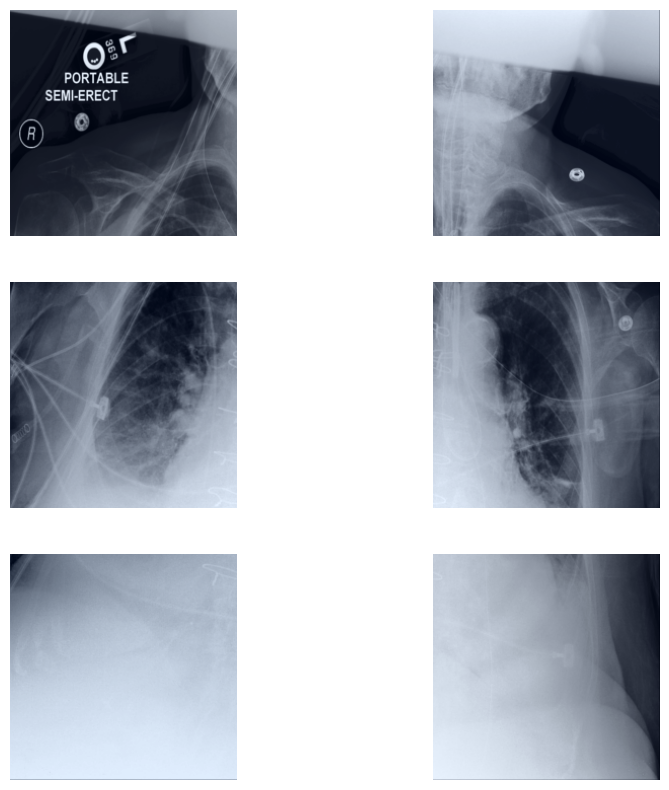

In [70]:
plt.figure(figsize=(10, 10))

for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.imshow(denormalize_image(datapoint['node_feat'][i]))
    plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

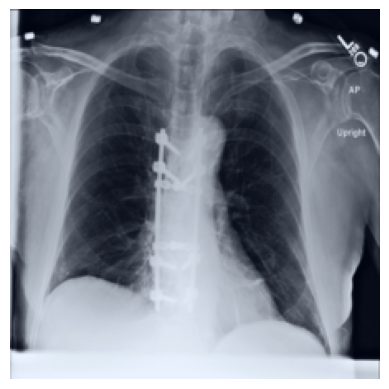

In [45]:
plt.imshow(denormalize_image(datapoint['global_feat']))
plt.axis('off')

In [47]:
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights, densenet121, DenseNet121_Weights, efficientnet_b0, EfficientNet_B0_Weights
import pytorch_lightning as pl
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAccuracy, BinaryAUROC
from model.matryoshka import Matryoshka_CE_Loss, MRL_Linear_Layer
from common_metrics import compute_metrics as retrieval_metrics
from graph_transformer.graph_transformer_pytorch import GraphTransformer
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR
from Res2Net.res2net import res2net50

/home2/arihanth.srikar/miniconda3/envs/pytorch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [84]:
class CustomModel(pl.LightningModule):
    def __init__(self, config, in_features=1024, out_features=1024, num_classes=9, num_nodes=18):
        super().__init__()
        assert config["residual_type"] > 0 and config["residual_type"] <= 3, 'Residual type should be 1, 2 or 3'
        print(f'Graph Tansformer using global features is {config["is_global_feat"]}' + ' in a constrastive manner' if config['contrastive'] else '')
        print(f'Using {["local gated residue","global gated residue", "dense gated residue"][config["residual_type"]-1]}')
        
        # image featurizer
        if 'resnet' in config['image_featuriser']:
            self.cnn = resnet50(weights=ResNet50_Weights.DEFAULT) if not config["multiscale"] else res2net50(pretrained=True)
            self.cnn.fc = nn.Sequential(
                nn.Linear(2048, 1024),
                nn.ReLU(),
                nn.Linear(1024, in_features),
            )
            # freeze weights of cnn
            for param in self.cnn.parameters():
                param.requires_grad = False
            for param in self.cnn.fc.parameters():
                param.requires_grad = True
        
        elif 'densenet' in config['image_featuriser']:
            self.cnn = densenet121(weights=DenseNet121_Weights.DEFAULT)
            self.cnn.classifier = nn.Identity()
            # freeze weights of cnn
            # for param in self.cnn.parameters():
            #     param.requires_grad = False

        elif 'efficientnet' in config['image_featuriser']:
            self.cnn = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
            self.cnn.classifier = nn.Sequential(
                nn.Linear(1280, 1024),
                nn.ReLU(),
                nn.Linear(1024, in_features),
            )
            # freeze weights of cnn
            # for param in self.cnn.parameters():
            #     param.requires_grad = False
            # for param in self.cnn.classifier.parameters():
            #     param.requires_grad = True

        else:
            raise NotImplementedError(f'Image featuriser {config["image_featuriser"]} not implemented')

        self.model = GraphTransformer(
            dim = in_features,
            depth = config['num_layers'],
            with_feedforwards=True,
            gated_residual=True,
            accept_adjacency_matrix=True,
            rel_pos_emb=config['rel_pos'],
            abs_pos_emb=config['abs_pos'],
        )

        self.fc = nn.Sequential(
            nn.LayerNorm(out_features),
            nn.Linear(out_features, num_classes) if not config['matryoshka'] else MRL_Linear_Layer(nesting_list=[8, 16, 32, 64, 128, 256, 512, 1024], 
                                                                                                   num_classes=num_classes, efficient=True)
        )

        if config['cls']:
            print('Using CLS token')
            self.register_buffer('cls_token', nn.Parameter(torch.zeros(1, out_features), requires_grad=True))
            nn.init.xavier_uniform_(self.cls_token)
        
        #anatomy adjacency matrix
        adj_mat_file = '/home/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/anatomy_matrix.csv'
        adj_mat = torch.from_numpy(pd.read_csv(adj_mat_file, sep='\t').to_numpy()).int()
        N, M = adj_mat.shape
        if config['is_global_feat']:
            assert N == M, 'Adjacency matrix should be square'
            N += 1 if not config['cls'] else 2
            M += 1 if not config['cls'] else 2
            temp_adj_mat = torch.ones((N, M))
            if not config['fully_connected']:
                temp_adj_mat[:-1, :-1] = adj_mat
        else:
            temp_adj_mat = adj_mat if not config['fully_connected'] else torch.ones_like(adj_mat)

        if num_nodes < 18:
            temp_adj_mat = torch.ones((num_nodes, num_nodes))
            N, M = temp_adj_mat.shape
        
        self.register_buffer('adj_mat', temp_adj_mat)
        if config['accept_edges']:
            self.register_buffer('edges', nn.Parameter(torch.zeros(N, M, out_features), requires_grad=True))
            nn.init.xavier_uniform_(self.edges)
        
        if config['contrastive']:
            hash_bits = config['hash_bits']
            self.hash_fn = nn.Sequential(
                nn.Linear(out_features, max(out_features//2, hash_bits)),
                nn.ReLU(),
                nn.Linear(max(out_features//2, hash_bits), hash_bits),
            )

        # hyperparameters
        self.config = config
        self.lr = config['lr']
        self.in_features = in_features
        self.out_features = out_features
        self.num_classes = num_classes
        self.num_nodes = num_nodes
        self.num_layers = config['num_layers']
        self.dropout = config['dropout']
        self.graph_importance = config['graph_importance']
        self.matryoshka = config['matryoshka']
        self.contrastive = config['contrastive']
        self.res_type = config['residual_type']
        
        self.save_hyperparameters()

        self.calc_metrics = {
                'f1': BinaryF1Score(),
                'auc': BinaryAUROC(),
                'acc': BinaryAccuracy(),
                'recall': BinaryRecall(),
                'precision': BinaryPrecision(),
            }
        
        self.node_lables = [
            'lung opacity', 
            'pleural effusion', 
            'atelectasis', 
            'enlarged cardiac silhouette',
            'pulmonary edema/hazy opacity', 
            'pneumothorax', 
            'consolidation', 
            'fluid overload/heart failure', 
            'pneumonia']
        self.graph_lables = [ 
            'Atelectasis',
            'Cardiomegaly',
            'Consolidation',
            'Edema',
            'Enlarged Cardiomediastinum',
            'Fracture',
            'Lung Lesion',
            'Lung Opacity',
            'No Finding',
            'Pleural Effusion',
            'Pleural Other',
            'Pneumonia',
            'Pneumothorax',
            'Support Devices']

        self.val_epoch_end_outputs_node = []
        self.val_epoch_end_outputs_graph = []
        self.test_epoch_end_outputs_node = []
        self.test_epoch_end_outputs_graph = []

        self.criterion = Matryoshka_CE_Loss(is_functional=True) if config['matryoshka'] else F.binary_cross_entropy_with_logits
        self.contrastive_criterion = nn.TripletMarginWithDistanceLoss(distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y))
        self.retrieval_metrics = retrieval_metrics

    def compute_metrics(self, logits, y):
        logits = logits.detach().cpu()
        y = y.detach().cpu()
        return {
            'f1': self.calc_metrics['f1'](logits, y),
            'auc': self.calc_metrics['auc'](logits, y),
            'acc': self.calc_metrics['acc'](logits, y),
            'recall': self.calc_metrics['recall'](logits, y),
            'precision': self.calc_metrics['precision'](logits, y),
        }

    def compute_loss(self, logits, y):
        return self.criterion(logits, y)
    
    def compute_contrastive_loss(self, anchor, positive, negative):
        return self.contrastive_criterion(anchor, positive, negative)

    def forward(self, images, y_node, y_graph, global_feat=None, return_loss=True, return_emb=False, masks=None, retrieval=False, consider_positions=True):
        # images (batch_size, anatomy_size, 3, 224, 224)
        # y (batch_size, anatomy_size, num_classes)
        images = torch.cat([images, global_feat.unsqueeze(1)], dim=1) if global_feat is not None else images
        B, N, C, H, W = images.shape
        images = images.reshape(B*N, C, H, W)

        # run it through the image featurizer (B*N, in_features)
        node_feats = self.cnn(images)

        # reshape back to (batch_size, anatomy_size, in_features)
        node_feats = node_feats.reshape(B, N, -1)

        # run model
        adj_mat = self.adj_mat.unsqueeze(0).repeat(B, 1, 1)
        edges = self.edges.unsqueeze(0).repeat(B, 1, 1, 1) if self.config['accept_edges'] else None
        node_feats = torch.cat([node_feats, self.cls_token.expand(B, -1, -1)], dim=1) if self.config['cls'] else node_feats
        node_feats, _, ret_emb = self.model(node_feats, adj_mat=adj_mat, residual_type=self.res_type, consider_positions=consider_positions) if edges is None else self.model(node_feats, edges, adj_mat=adj_mat, residual_type=self.res_type, consider_positions=consider_positions)
        
        # for classification
        logits = self.fc(node_feats)
        ret_emb = ret_emb if retrieval else node_feats
        if global_feat is not None or self.config['cls']:
            node_logits = logits[:, :self.num_nodes, :]
            graph_emb = ret_emb[:, -1, :] if self.config['pool'] == 'attn' else torch.mean(ret_emb[:, :self.num_nodes, :], dim=1)
        else:
            node_logits = logits
            graph_emb = torch.mean(ret_emb, dim=1)
        graph_logits = self.fc(graph_emb)
        
        if not return_loss:
            return (node_logits, graph_logits, graph_emb) if return_emb else (node_logits, graph_logits)
        
        loss_node = self.compute_loss(node_logits, y_node)
        loss_graph = self.compute_loss(graph_logits, y_graph)
        loss = loss_graph * self.graph_importance + loss_node * (1 - self.graph_importance)
        
        return (node_logits, graph_logits, graph_emb, loss) if return_emb else (node_logits, graph_logits, loss)
    
    def training_step(self, batch, batch_idx):
        y_node = batch['y']
        y_graph = (torch.sum(y_node, dim=1) > 0).float()
        global_feat = batch['global_feat'] if self.config['is_global_feat'] else None
        node_logits, graph_logits, loss = self(batch['node_feat'], y_node, y_graph, global_feat, masks=batch['masked_img'])

        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('lr', self.trainer.optimizers[0].param_groups[0]['lr'], on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('graph_importance', self.graph_importance, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        y_node = batch['y']
        y_graph = (torch.sum(y_node, dim=1) > 0).float()
        global_feat = batch['global_feat'] if self.config['is_global_feat'] else None
        node_logits, graph_logits, graph_emb, loss = self(batch['node_feat'], y_node, y_graph, global_feat, return_emb=True, masks=batch['masked_img'])
        
        node_logits = node_logits[-1] if self.matryoshka else node_logits
        graph_logits = graph_logits[-1] if self.matryoshka else graph_logits

        self.val_epoch_end_outputs_node.append((node_logits.detach().cpu(), y_node.detach().cpu(), loss.detach().cpu()))
        self.val_epoch_end_outputs_graph.append((graph_logits.detach().cpu(), y_graph.detach().cpu(), graph_emb.detach().cpu()))

        return loss
    
    def test_step(self, batch, batch_idx):
        y_node = batch['y']
        y_graph = (torch.sum(y_node, dim=1) > 0).float()
        global_feat = batch['global_feat'] if self.config['is_global_feat'] else None
        node_logits, graph_logits, graph_emb, loss = self(batch['node_feat'], y_node, y_graph, global_feat, return_emb=True, masks=batch['masked_img'])

        node_logits = node_logits[-1] if self.matryoshka else node_logits
        graph_logits = graph_logits[-1] if self.matryoshka else graph_logits

        self.test_epoch_end_outputs_node.append((node_logits.detach().cpu(), y_node.detach().cpu(), loss.detach().cpu()))
        self.test_epoch_end_outputs_graph.append((graph_logits.detach().cpu(), y_graph.detach().cpu(), graph_emb.detach().cpu()))

        return loss
    
    @torch.no_grad()
    def on_validation_epoch_end(self) -> None:
    
        node_logits, node_y, node_losses = zip(*self.val_epoch_end_outputs_node)
        node_logits = torch.cat(node_logits)
        node_y = torch.cat(node_y)
        loss = torch.mean(torch.tensor(list(node_losses)))
        
        graph_logits, graph_y, graph_emb = zip(*self.val_epoch_end_outputs_graph)
        graph_logits = torch.cat(graph_logits)
        graph_y = torch.cat(graph_y)
        graph_emb = torch.cat(graph_emb)

        self.common_end_epoch_function(node_logits, node_y, loss, graph_logits, graph_y, graph_emb, 'val')
    
        self.val_epoch_end_outputs_node = []
        self.val_epoch_end_outputs_graph = []
    
    @torch.no_grad()
    def on_test_epoch_end(self):

        node_logits, node_y, node_losses = zip(*self.test_epoch_end_outputs_node)
        node_logits = torch.cat(node_logits)
        node_y = torch.cat(node_y)
        loss = torch.mean(torch.tensor(list(node_losses)))
        
        graph_logits, graph_y, graph_emb = zip(*self.test_epoch_end_outputs_graph)
        graph_logits = torch.cat(graph_logits)
        graph_y = torch.cat(graph_y)
        graph_emb = torch.cat(graph_emb)

        self.common_end_epoch_function(node_logits, node_y, loss, graph_logits, graph_y, graph_emb, 'test')
    
        self.test_epoch_end_outputs_node = []
        self.test_epoch_end_outputs_graph = []
    
    @torch.no_grad()
    def common_end_epoch_function(self, node_logits, node_y, loss, graph_logits, graph_y, graph_emb, split):

        average_metrics = {
            'acc': [],
            'auc': [],
            'f1': [],
            'precision': [],
            'recall': [],
        }

        # retrieval
        _, mAP, mHR, mRR = self.retrieval_metrics(self.config, split, graph_emb.numpy(), graph_y.numpy(), 
                                                  self.node_lables, top_k=10, dist_metric='cosine', is_save=False)
        self.log(f'{split}_mAP', mAP, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'{split}_mHR', mHR, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'{split}_mRR', mRR, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        # graph level classification
        for i, lable_name in enumerate(self.node_lables):
            metrics = self.compute_metrics(graph_logits[:, i], graph_y[:, i])

            self.log(f'{split}_{lable_name}_acc', metrics['acc'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
            self.log(f'{split}_{lable_name}_auc', metrics['auc'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
            self.log(f'{split}_{lable_name}_f1', metrics['f1'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
            self.log(f'{split}_{lable_name}_precision', metrics['precision'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
            self.log(f'{split}_{lable_name}_recall', metrics['recall'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

            average_metrics['acc'].append(metrics['acc'].item())
            average_metrics['auc'].append(metrics['auc'].item())
            average_metrics['f1'].append(metrics['f1'].item())
            average_metrics['precision'].append(metrics['precision'].item())
            average_metrics['recall'].append(metrics['recall'].item())

        self.log(f'{split}_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'{split}_acc', np.mean(average_metrics['acc']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'{split}_auc', np.mean(average_metrics['auc']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'{split}_f1', np.mean(average_metrics['f1']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'{split}_precision', np.mean(average_metrics['precision']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'{split}_recall', np.mean(average_metrics['recall']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        average_metrics = {
            'acc': [],
            'auc': [],
            'f1': [],
            'precision': [],
            'recall': [],
        }
        
        # node level classification
        for i, lable_name in enumerate(self.node_lables):
            metrics = self.compute_metrics(node_logits[:, :, i], node_y[:, :, i])

            self.log(f'node_{split}_{lable_name}_acc', metrics['acc'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
            self.log(f'node_{split}_{lable_name}_auc', metrics['auc'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
            self.log(f'node_{split}_{lable_name}_f1', metrics['f1'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
            self.log(f'node_{split}_{lable_name}_precision', metrics['precision'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
            self.log(f'node_{split}_{lable_name}_recall', metrics['recall'].item(), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

            average_metrics['acc'].append(metrics['acc'].item())
            average_metrics['auc'].append(metrics['auc'].item())
            average_metrics['f1'].append(metrics['f1'].item())
            average_metrics['precision'].append(metrics['precision'].item())
            average_metrics['recall'].append(metrics['recall'].item())

        self.log(f'node_{split}_acc', np.mean(average_metrics['acc']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'node_{split}_auc', np.mean(average_metrics['auc']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'node_{split}_f1', np.mean(average_metrics['f1']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'node_{split}_precision', np.mean(average_metrics['precision']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log(f'node_{split}_recall', np.mean(average_metrics['recall']), on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    @torch.no_grad()
    def retrieval_pass(self, images, global_feat=None, consider_positions=True):
        _, _, graph_emb = self(images, None, None, global_feat=global_feat if self.config['is_global_feat'] else None, 
                               return_loss=False, return_emb=True, masks=None, retrieval=True, consider_positions=consider_positions)
        
        global_emb = self.cnn(global_feat) if global_feat is not None and self.config['concat_global_feature'] else None
        graph_emb = torch.cat([graph_emb, global_emb], dim=1) if global_emb is not None else graph_emb
        
        return graph_emb
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.config['lr'])
        if self.config['lr_scheduler'] == 'one_cycle':
            scheduler = OneCycleLR(optimizer, max_lr=self.config['lr'], total_steps=self.config['num_steps'])
            scheduler = {'scheduler': scheduler, 'interval': 'step'}
        elif self.config['lr_scheduler'] == 'cosine':
            scheduler = CosineAnnealingLR(optimizer, T_max=self.config['num_steps']//2, eta_min=self.config['lr']/100)
            scheduler = {'scheduler': scheduler, 'interval': 'step'}
        else:
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)
            scheduler = {'scheduler': scheduler, 'monitor': 'val_loss'}
        
        return [optimizer], scheduler

In [85]:
model = CustomModel(config = {
    'lr': 0.0001,
    'num_layers': 2,
    'graph_importance': 1.0,
    'dropout': 0.0,
    'fully_connected': True,
    'contrastive': False,
    'concat_global_feature': False,
    'image_featuriser': 'resnet',
    'multiscale': False,
    'is_global_feat': False,
    'cls': False,
    'matryoshka': False,
    'rel_pos': False,
    'abs_pos': True,
    'accept_edges': True,
    'residual_type': 2,
    'task': 'graph_transformer',
    'run': 'best_config_abs_pos_with_edges',
}, in_features=1024, out_features=1024, num_classes=9, num_nodes=6)


Using global gated residue


In [94]:
batch = next(iter(test_dataloader))

y_node = batch['y']
y_graph = (torch.sum(y_node, dim=1) > 0).float()
global_feat = None
node_logits, graph_logits, loss = model(batch['node_feat'], y_node, y_graph, global_feat)

(torch.Size([2, 6, 3, 224, 224]), torch.Size([2, 6, 9]))